In [ ]:
!pip install biosppy peakutils neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 11.4 MB/s eta 0:00:00


In [217]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import neurokit2 as nk
import ast
#import biosppy.signals.ecg as ecg

In [236]:
sample_freq = 500   # Hz

metadata_full = pd.read_csv('metadata.csv')
metadata = metadata_full.head(20)
metadata = metadata.drop(columns=['Date', 'Patient_ID'])
metadata['Age'].astype(np.int32)
metadata['N'].astype(np.int32)
health_metadata = metadata.loc[metadata['AHA_Code'] == '1']
health_ECG_ID = health_metadata['ECG_ID'].values

ecg_signals = []

for i in health_ECG_ID:
    with h5py.File(f'records/record1/{i}.h5', 'r') as f:
        ecg_signals.append(f['ecg'][()])

In [237]:
health_metadata

,ECG_ID,AHA_Code,Age,Sex,N
1,A00002,1,32,M,6000
2,A00003,1,63,M,6500
5,A00006,1,46,F,5000
7,A00008,1,32,M,5000
8,A00009,1,48,F,6000
9,A00010,1,32,F,7500
11,A00012,1,58,M,6000
13,A00014,1,34,F,5000
15,A00016,1,24,F,5000
16,A00017,1,64,M,5000


In [242]:
annotations = []

for idx, (ecg_id, signal) in enumerate(zip(health_ECG_ID, ecg_signals)):
    record_annotations = {
        'id': ecg_id,
        'age': health_metadata.loc[health_metadata['ECG_ID'] == ecg_id, 'Age'].values[0],
        'sex': health_metadata.loc[health_metadata['ECG_ID'] == ecg_id, 'Sex'].values[0]
    }

    for channel in range(12):
        channel_signal = signal[channel, :]
        try:
            signals, info = nk.ecg_process(channel_signal, sampling_rate=sample_freq)

            record_annotations[f'channel_{channel}_P'] = list(info['ECG_P_Peaks']) if isinstance(info['ECG_P_Peaks'], (np.ndarray, list)) else []
            record_annotations[f'channel_{channel}_QRS'] = list(info['ECG_R_Peaks']) if isinstance(info['ECG_R_Peaks'], (np.ndarray, list)) else []
            record_annotations[f'channel_{channel}_T'] = list(info['ECG_T_Peaks']) if isinstance(info['ECG_T_Peaks'], (np.ndarray, list)) else []
            record_annotations[f'channel_{channel}_RR'] = list(np.diff(info['ECG_R_Peaks'])) if isinstance(info['ECG_R_Peaks'], (np.ndarray, list)) else []
        except Exception as e:
            print(f"Ошибка при обработке записи {i}, канал {channel}: {e}")

    annotations.append(record_annotations)

df = pd.DataFrame(annotations)
df.to_csv('ecg_annotations.csv', index=False)

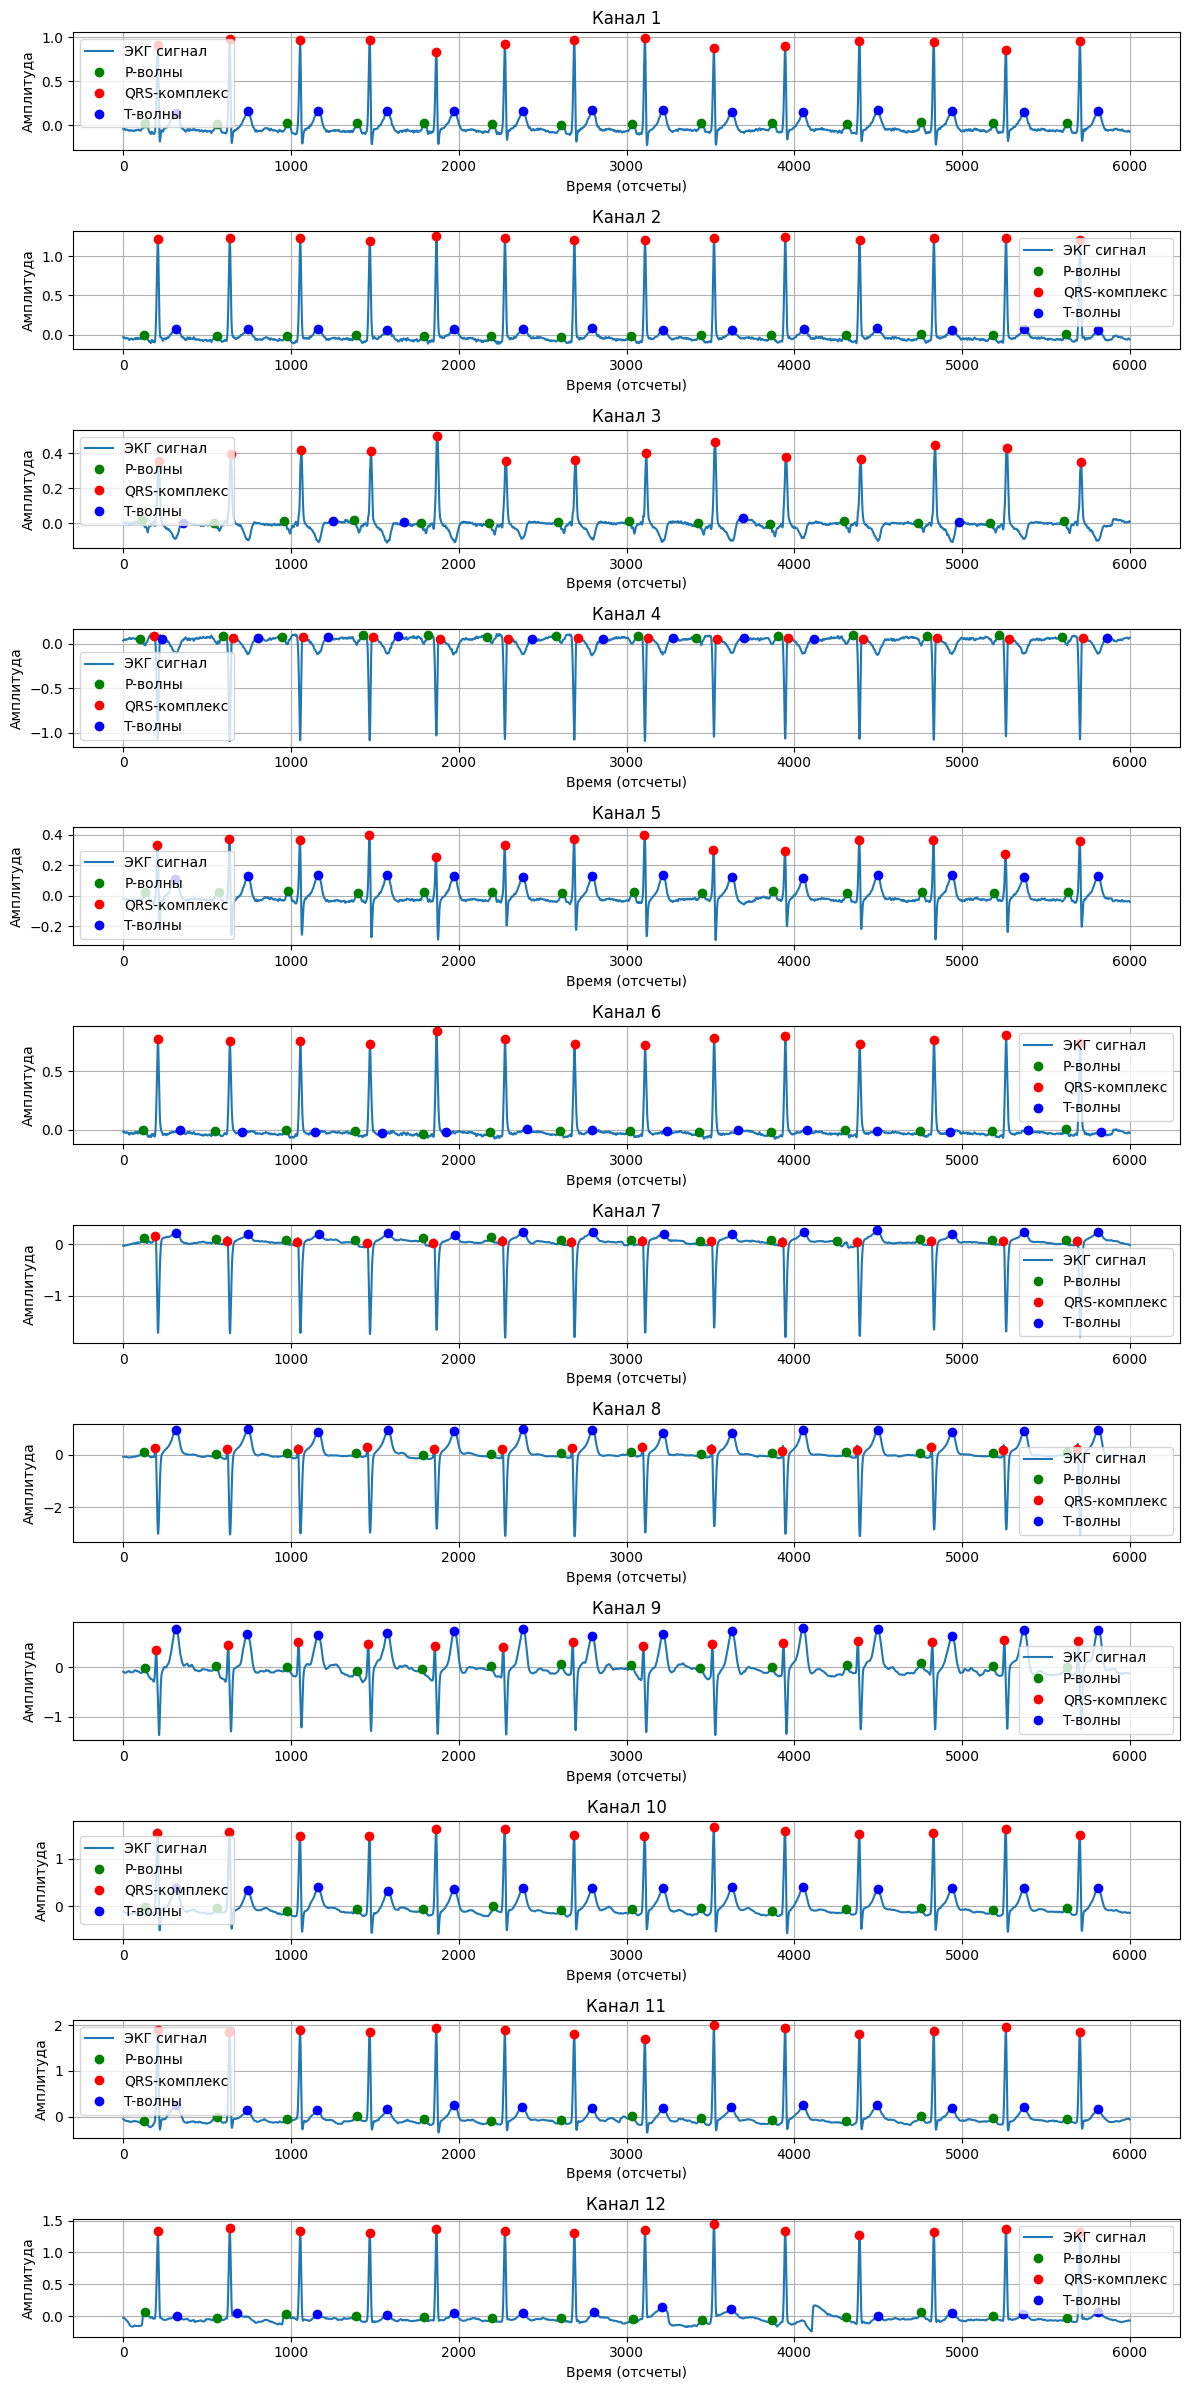

In [244]:
df = pd.read_csv('ecg_annotations.csv')

record_index = 0
record = df.iloc[record_index]

with h5py.File('record1/A00002.h5', 'r') as f:
    ecg_signals = f['ecg'][()]

fig, axes = plt.subplots(12, 1, figsize=(12, 24))

for channel_index in range(12):
    channel_signal = ecg_signals[channel_index, :]

    def safe_literal_eval(value):
        if isinstance(value, str) and 'nan' in value:
            value = value.replace('nan', '[]')
        return ast.literal_eval(value) if value else []

    p_peaks = safe_literal_eval(record[f'channel_{channel_index}_P'])
    qrs_peaks = safe_literal_eval(record[f'channel_{channel_index}_QRS'])
    t_peaks = safe_literal_eval(record[f'channel_{channel_index}_T'])

    t_peaks = [peak for peak in t_peaks if isinstance(peak, (int, float, np.number))]

    axes[channel_index].plot(channel_signal, label='ЭКГ сигнал')
    axes[channel_index].plot(p_peaks, channel_signal[p_peaks], 'go', label='P-волны')
    axes[channel_index].plot(qrs_peaks, channel_signal[qrs_peaks], 'ro', label='QRS-комплекс')
    axes[channel_index].plot(t_peaks, channel_signal[t_peaks], 'bo', label='T-волны')

    axes[channel_index].set_title(f'Канал {channel_index + 1}')
    axes[channel_index].set_xlabel('Время (отсчеты)')
    axes[channel_index].set_ylabel('Амплитуда')
    axes[channel_index].legend()
    axes[channel_index].grid()

plt.tight_layout()
plt.show()